In [66]:
import numpy as np 
import torch
import torchvision 
import torch.nn as nn
import torch.nn.functional as f
torch.__version__

'1.12.1+cu116'

In [67]:
import nbformat
# run the preprocessing notebook within this notebook to get the custom dataset objects
%run preprocessing.ipynb #https://stackoverflow.com/questions/20186344/importing-an-ipynb-file-from-another-ipynb-file

x_train shape: (50000, 32, 32, 3)
x_test shape:  (10000, 32, 32, 3)
y_train shape:  (50000,)
y_test shape:  (10000,)
(32, 32, 3)
data shape check
train set: (50000, 32, 32, 3)
test set: (10000, 32, 32, 3)
label numbers: 10


In [68]:
from torchvision import datasets
import torchvision.transforms as transforms 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

# train_dataset = datasets.CIFAR10(root="./", train=True, download=False, transform=transform)
# test_dataset = datasets.CIFAR10(root="./", train=False, download=False, transform=transform)

print(train_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [69]:
train_dataset[0][0].size() #verify dimensions 

torch.Size([3, 32, 32])

In [70]:
class ConvNet(nn.Module): 
  def __init__(self, output_dim): 
    super().__init__() 

    #two layesr for convolution 
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) 
    self.maxPool1 = nn.MaxPool2d(kernel_size=2) #32x32 -> 16x16

    self.conv2 = nn.Conv2d(64, 10, kernel_size=3, padding=1)
    self.maxPool2 = nn.MaxPool2d(kernel_size=2) #16x16 -> 8x8

    #two fully connected layers 
    self.fc1 = nn.Linear(640, 2080) #8x8x10 = 640
    self.fc2 = nn.Linear(2080, output_dim)
    
  def forward(self, x): #forward prop 
    x= f.relu(self.conv1(x)) 
    x = self.maxPool1(x)
    x= f.relu(self.conv2(x)) 
    x = self.maxPool2(x)

    x = torch.flatten(x, 1)

    x = f.relu(self.fc1(x))
    x = self.fc2(x)

    return x 

In [71]:
DEVICE = torch.device("cuda") # for using gpu 
OUTPUT_DIM = 10 
LEARNING_RATE = 0.001
NUM_EPOCHS = 5 
print(DEVICE)
torch.manual_seed(87)

cuda


In [72]:
model = ConvNet(OUTPUT_DIM).to(DEVICE) 
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [73]:
def eval_accuracy(loader): 
  model.eval() #set model to inference 
  yTrue = []
  yPred = []

  count = 0 
  accuracy_sum = 0 

  with torch.no_grad(): 
    for x, y, in loader: 
      x = x.float().to(DEVICE)
      y = y.to(DEVICE)
      outputs = model.forward(x)

      outputs = outputs.cpu().numpy() 
      yPred = np.argmax(outputs, axis=1)
      y = y.cpu().numpy()

      match = (y == yPred).astype('uint8')
      accuracy_sum += np.sum(match)
      count += len(match)

  accuracy = accuracy_sum/count 
  return accuracy 

In [74]:
model.train() #Sets the module in training mode.
avg_losses = []
for i in range(NUM_EPOCHS): 
  loss_record = []

  # x=input image y=label 
  for(x, y) in train_loader: 
    x = x.float().to(DEVICE) 
    y = y.type(torch.LongTensor) #stackoverflow https://stackoverflow.com/questions/69742930/runtimeerror-nll-loss-forward-reduce-cuda-kernel-2d-index-not-implemented-for
    y = y.to(DEVICE)

    outputs = model.forward(x)
    loss = criterion(outputs, y) 
    loss_record.append(loss.item())

    optimizer.zero_grad() #reset gradient for each batch 
    loss.backward() 
    optimizer.step() 

  avg_loss = np.mean(loss_record)
  avg_losses.append(avg_loss)
  print("Average Loss at epoch %d: %.4f" %(i+1, avg_loss))
  train_accuracy = eval_accuracy(train_loader)
  test_accuracy = eval_accuracy(test_loader)
  print("train accuracy: %.4f" %(train_accuracy))
  print("test accuracy: %.4f" %(test_accuracy))



Average Loss at epoch 1: 2.1523
train accuracy: 0.3115
test accuracy: 0.3217
Average Loss at epoch 2: 1.8070
train accuracy: 0.3945
test accuracy: 0.3991
Average Loss at epoch 3: 1.6350
train accuracy: 0.4479
test accuracy: 0.4466
Average Loss at epoch 4: 1.5231
train accuracy: 0.4728
test accuracy: 0.4694
Average Loss at epoch 5: 1.4432
train accuracy: 0.5008
test accuracy: 0.4925


In [75]:
print(avg_losses)

[2.1522570256991767, 1.8070406889366677, 1.635048664744248, 1.5231098714082136, 1.443206578874222]


[1, 2, 3, 4, 5]


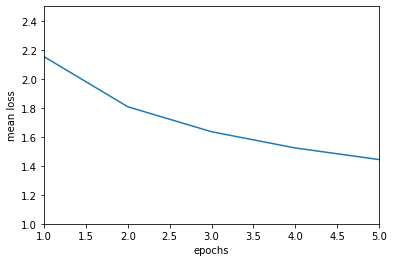

In [79]:
import matplotlib.pyplot as plt
x_axis = [i for i in range(1, NUM_EPOCHS+1)]
print(x_axis)
plt.xlabel('epochs')
plt.ylabel('mean loss')
plt.axis([1, NUM_EPOCHS, 1, 2.5])
plt.plot(x_axis, avg_losses)